# Prediction using XGBoost

In [81]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

## Telco churn data

### Data loading and pre-processing

In [86]:
df = pd.read_csv('Telco_customer_churn.csv', delimiter=';')

In [87]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783","33,964131","-118,272783",Male,...,Month-to-month,Yes,Mailed check,"53,85","108,15",Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742","34,059281","-118,307420",Female,...,Month-to-month,Yes,Electronic check,"70,7","151,65",Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953","34,048013","-118,293953",Female,...,Month-to-month,Yes,Electronic check,"99,65","820,5",Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709","34,062125","-118,315709",Female,...,Month-to-month,Yes,Electronic check,"104,8","3046,05",Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293","34,039224","-118,266293",Male,...,Month-to-month,Yes,Bank transfer (automatic),"103,7","5036,3",Yes,1,89,5340,Competitor had better devices


Drop unnecessary or unique columns

In [88]:
df.drop(columns=['Count','Country','State','CustomerID','Lat Long','Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'], inplace=True)

Remove whitespace in city names and column names

In [89]:
df['City'].replace(' ', '_', regex=True, inplace=True)

In [90]:
df.columns = df.columns.str.replace(' ', '_')

Look at the datatypes

In [91]:
df.dtypes

City                 object
Zip_Code              int64
Latitude             object
Longitude            object
Gender               object
Senior_Citizen       object
Partner              object
Dependents           object
Tenure_Months         int64
Phone_Service        object
Multiple_Lines       object
Internet_Service     object
Online_Security      object
Online_Backup        object
Device_Protection    object
Tech_Support         object
Streaming_TV         object
Streaming_Movies     object
Contract             object
Paperless_Billing    object
Payment_Method       object
Monthly_Charges      object
Total_Charges        object
Churn_Value           int64
dtype: object

Set empty strings / spaces to 0

In [92]:
df.loc[(df['Total_Charges']==' '),'Total_Charges'] = 0

In [93]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'].str.replace(',', '.'))

In [94]:
df['Latitude'] = pd.to_numeric(df['Latitude'].str.replace(',', '.'))
df['Longitude'] = pd.to_numeric(df['Longitude'].str.replace(',', '.'))
df['Monthly_Charges'] = pd.to_numeric(df['Monthly_Charges'].str.replace(',', '.'))

Replace spaces in whole dataframe with _

In [95]:
df.replace(' ', '_', regex=True, inplace=True)

In [96]:
df

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Landers,92285,34.341737,-116.539416,Female,No,No,No,72,Yes,...,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,Yes,Bank_transfer_(automatic),21.15,1419.40,0
7039,Adelanto,92301,34.667815,-117.536183,Male,No,Yes,Yes,24,Yes,...,Yes,Yes,Yes,Yes,One_year,Yes,Mailed_check,84.80,1990.50,0
7040,Amboy,92304,34.559882,-115.637164,Female,No,Yes,Yes,72,Yes,...,Yes,No,Yes,Yes,One_year,Yes,Credit_card_(automatic),103.20,7362.90,0
7041,Angelus_Oaks,92305,34.167800,-116.864330,Female,No,Yes,Yes,11,No,...,No,No,No,No,Month-to-month,Yes,Electronic_check,29.60,346.45,0


### Split data into dependent and independent variables

In [97]:
X = df.drop('Churn_Value', axis=1).copy()
y = df['Churn_Value'].copy()

### One-hot encoding

In [98]:
X.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
dtype: object

All object columns need to be inspected and categorical data has to be encoded

In [99]:
X_encoded = pd.get_dummies(X, columns=['City', 'Gender','Partner', 'Dependents', 'Phone_Service', 'Multiple_Lines', \
                                      'Internet_Service', 'Online_Security', 'Online_Backup', 'Device_Protection',\
                                      'Tech_Support', 'Streaming_TV', 'Streaming_Movies', 'Contract', 'Paperless_Billing',\
                                      'Payment_Method', 'Senior_Citizen'])

In [100]:
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check,Senior_Citizen_No,Senior_Citizen_Yes
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0


y should only contain 1s and 0s

In [101]:
y.unique()

array([1, 0])

### Build preliminary XGBoost Model

In [102]:
sum(y)/len(y)

0.2653698707936959

--> percentage of people that left the company

--> we need to use stratification to ensure that the same percentage is present in both the train and test set

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

Verify that stratify worked:

In [104]:
print(sum(y_train)/len(y_train), sum(y_test)/len(y_test))

0.2654297614539947 0.26519023282226006


In [111]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=1, seed=42, use_label_encoder=False)

In [112]:
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.64036
[1]	validation_0-aucpr:0.64414
[2]	validation_0-aucpr:0.65129
[3]	validation_0-aucpr:0.65314
[4]	validation_0-aucpr:0.65515
[5]	validation_0-aucpr:0.65397
[6]	validation_0-aucpr:0.64819
[7]	validation_0-aucpr:0.64909
[8]	validation_0-aucpr:0.65366
[9]	validation_0-aucpr:0.65075
[10]	validation_0-aucpr:0.65011
[11]	validation_0-aucpr:0.65012
[12]	validation_0-aucpr:0.65120
[13]	validation_0-aucpr:0.65151


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=1, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

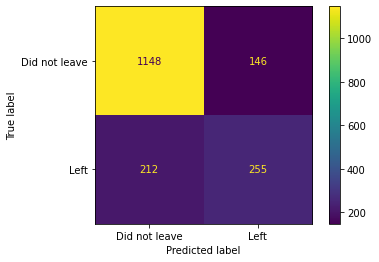

In [113]:
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d', display_labels=['Did not leave', 'Left'])

--> Not good because dataset is imbalanced!

Use scale_pos_weight penalty for incorrectly labeling the 

### Optimization using Cross Validation and GridSearch

In [115]:
#TODO: later

### Draw first tree

In [121]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42, use_label_encoder=True, n_estimators=1)
clf_xgb.fit(X_train, y_train)

[12:45:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1631904775127/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/wikipedia/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=1, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

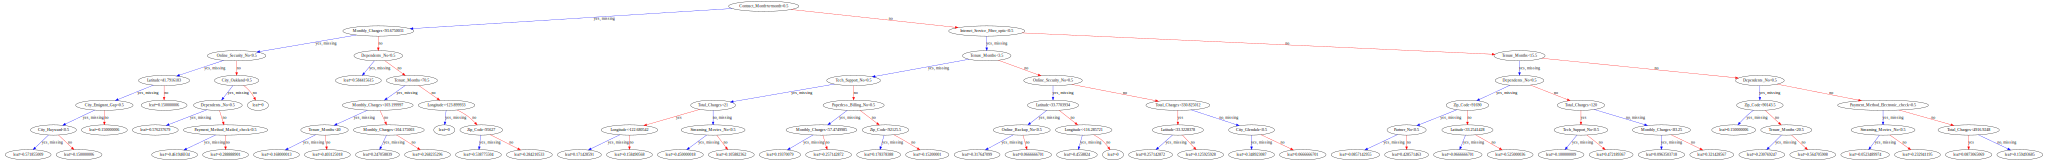

In [122]:
xgb.to_graphviz(clf_xgb, num_trees=0, size='10,10')

## Wikipedia data

In [58]:
df_pop = pd.read_csv('../../data/popular_data.csv')

In [59]:
df_pop

,Unnamed: 0,infobox_key,page_title,property_name,template,previous_value,current_value,timestamp,days_diff
0,93,216369130-0,NCSoft,name,infobox company,NCSOFT Corporation<br/>엔씨소프트,NCsoft Corporation<br/>엔씨소프트,2017-01-15 16:52:10+00:00,606 days 15:01:36
1,94,216369130-0,NCSoft,name,infobox company,NCsoft Corporation<br/>엔씨소프트,NCSOFT Corporation<br/>엔씨소프트,2017-05-30 20:04:15+00:00,135 days 03:12:05
2,95,216369130-0,NCSoft,name,infobox company,NCSOFT Corporation<br/>엔씨소프트,NCSoft Corporation<br/>엔씨소프트,2018-09-30 11:38:58+00:00,487 days 15:34:43
3,663,27792315-0,Wildflowers (Tom Petty album),genre,infobox album,"[[Heartland rock]],[[ Hard rock]]",[[Heartland rock]],2015-07-10 09:16:12+00:00,661 days 05:46:00
4,664,27792315-0,Wildflowers (Tom Petty album),genre,infobox album,[[Heartland rock]],{{flatlist|\n* [[Heartland rock]]\n* [[rock an...,2015-09-03 15:28:03+00:00,55 days 06:11:51
...,...,...,...,...,...,...,...,...,...
6524481,64239164,134041145-0,François Truffaut,spouse,infobox person,{{marriage|Madeleine Morgenstern|1957|1965}} (...,{{marriage|Madeleine Morgenstern|1957|1965|end...,2016-02-06 21:31:24+00:00,963 days 15:58:29
6524482,64239165,134041145-0,François Truffaut,spouse,infobox person,{{marriage|Madeleine Morgenstern|1957|1965|end...,"Madeleine Morgenstern<br>(1957－1965, 2 daughters)",2016-05-20 12:28:44+00:00,103 days 14:57:20
6524483,64239166,134041145-0,François Truffaut,spouse,infobox person,"Madeleine Morgenstern<br>(1957－1965, 2 daughters)","Madeleine Morgenstern<br>(1957–1965, 2 daughters)",2017-09-07 20:57:16+00:00,475 days 08:28:32
6524484,64239167,134041145-0,François Truffaut,spouse,infobox person,"Madeleine Morgenstern<br>(1957–1965, 2 daughters)",{{marriage|Madeleine Morgenstern<br>|1957|1965...,2018-06-09 10:06:14+00:00,274 days 13:08:58


In [ ]:
df['time_til_next_change'] = df.groupby(['infobox_key', 'property_name'])['days_diff'].shift(-1)

In [ ]:
df['time_til_next_change'] = df['time_til_next_change'].fillna(0)

In [ ]:
df['time_til_next_change'] = df['time_til_next_change'].apply(lambda x: pd.Timedelta(x).total_seconds()/(3600*24))

In [ ]:
df['time_til_next_change'] = df['time_til_next_change'].apply(lambda x: round(x))

In [ ]:
train = df[(df['page_title']=='David Beckham') & (df['property_name']=='caps(goals)')]['time_til_next_change']

In [ ]:
train

1793288      1
1793289     13
1793290      1
1793291    135
1793292      6
          ... 
1793391     14
1793392      0
1793656     23
1793657      7
1793658      0
Name: time_til_next_change, Length: 108, dtype: int64

In [ ]:
last_update = df[(df['page_title']=='David Beckham') & (df['property_name']=='caps(goals)')]['timestamp'].iloc[-1]

In [ ]:
last_update = pd.to_datetime(last_update)

In [ ]:
last_update

Timestamp('2009-04-27 21:42:25+0000', tz='UTC')

In [ ]:
len(train)

108

In [ ]:
supervised_train = series_to_supervised(train.values, n_in=1)

In [19]:
supervised_train

array([[  1.,  13.],
       [ 13.,   1.],
       [  1., 135.],
       [135.,   6.],
       [  6.,  62.],
       [ 62.,  47.],
       [ 47.,  13.],
       [ 13.,   2.],
       [  2.,  16.],
       [ 16.,  47.],
       [ 47.,  21.],
       [ 21.,  15.],
       [ 15.,   7.],
       [  7.,  23.],
       [ 23.,   3.],
       [  3.,   3.],
       [  3.,   9.],
       [  9.,   3.],
       [  3.,   5.],
       [  5.,   7.],
       [  7.,   4.],
       [  4.,   1.],
       [  1.,   7.],
       [  7.,  14.],
       [ 14.,   7.],
       [  7.,  31.],
       [ 31.,   0.],
       [  0.,  36.],
       [ 36.,   4.],
       [  4.,   6.],
       [  6.,   6.],
       [  6.,   2.],
       [  2.,   1.],
       [  1.,   1.],
       [  1.,   5.],
       [  5.,   2.],
       [  2.,   5.],
       [  5.,   1.],
       [  1.,   1.],
       [  1.,   1.],
       [  1.,   9.],
       [  9.,   1.],
       [  1.,   6.],
       [  6.,   5.],
       [  5.,   4.],
       [  4.,   1.],
       [  1.,   7.],
       [  7.,

In [20]:
mae, y, yhat = walk_forward_validation(supervised_train, 7)

(1,) ()


/opt/homebrew/Caskroom/miniforge/base/envs/wikipedia/lib/python3.6/site-packages/xgboost/data.py:122: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


testX:  [1.]
>expected=13.0, predicted=15.9
(1,) ()
testX:  [13.]
>expected=1.0, predicted=3.0
(1,) ()
testX:  [1.]
>expected=135.0, predicted=15.7
(1,) ()
testX:  [135.]
>expected=6.0, predicted=6.0
(1,) ()
testX:  [6.]
>expected=62.0, predicted=14.6
(1,) ()
testX:  [62.]
>expected=47.0, predicted=47.0
(1,) ()
testX:  [47.]
>expected=13.0, predicted=17.0
(1,) ()
testX:  [13.]
>expected=2.0, predicted=2.5
(1,) ()
testX:  [2.]
>expected=16.0, predicted=6.5
(1,) ()
testX:  [16.]
>expected=47.0, predicted=32.0
(1,) ()
testX:  [47.]
>expected=21.0, predicted=15.7
(1,) ()
testX:  [21.]
>expected=15.0, predicted=15.0
(1,) ()
testX:  [15.]
>expected=7.0, predicted=7.0
(1,) ()
testX:  [7.]
>expected=23.0, predicted=10.1
(1,) ()
testX:  [23.]
>expected=3.0, predicted=5.0
(1,) ()
testX:  [3.]
>expected=3.0, predicted=8.0
(1,) ()
testX:  [3.]
>expected=9.0, predicted=7.5
(1,) ()
testX:  [9.]
>expected=3.0, predicted=5.2
(1,) ()
testX:  [3.]
>expected=5.0, predicted=7.7
(1,) ()
testX:  [5.]
>expec

NameError: name 'test' is not defined